# Loading Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, norm, ttest_ind

# Loading Project Dataset

In [ ]:
data = pd.read_csv('~/Downloads/marketing_AB.csv')

data.head(1)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20


# Cleaning The Dataset

### Dropping Unnecessary Columns

In [ ]:
data.drop(columns=['Unnamed: 0', 'user id'], inplace = True)

data.head(1)

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20


### Checking For Data Types And Presence Of Nulls

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   test group     588101 non-null  object
 1   converted      588101 non-null  bool  
 2   total ads      588101 non-null  int64 
 3   most ads day   588101 non-null  object
 4   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 18.5+ MB


There are no nulls in the dataset and the data types also seem correct

### Checking Values In Categorical Columns And Updating Their Values Into More Readable Format If Required

In [8]:
data['test group'].unique()

array(['ad', 'psa'], dtype=object)

In [9]:
data['test group'] = np.where(data['test group'] == 'ad', 1, 0)

In [10]:
data['converted'].unique()

array([False,  True])

In [11]:
data['converted'] = np.where(data['converted'] == False, 0, 1)

# Creating Data Visualizations To Understand Feature Distributions And Relationships

### Visualizing Test And Control Group Cohort Sizes

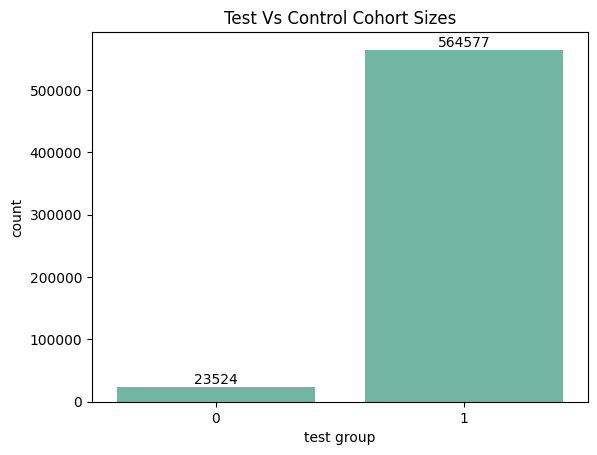

In [116]:
sns.set_palette('Set2')

ax = sns.countplot(x = 'test group', data=data)

for container in ax.containers:
    ax.bar_label(container)

ax.set_title('Test Vs Control Cohort Sizes')

plt.show()

Test group contains ~24x the number of users compared to the control group

### Visualizing The Cohort Sizes Broken Down By The Conversions

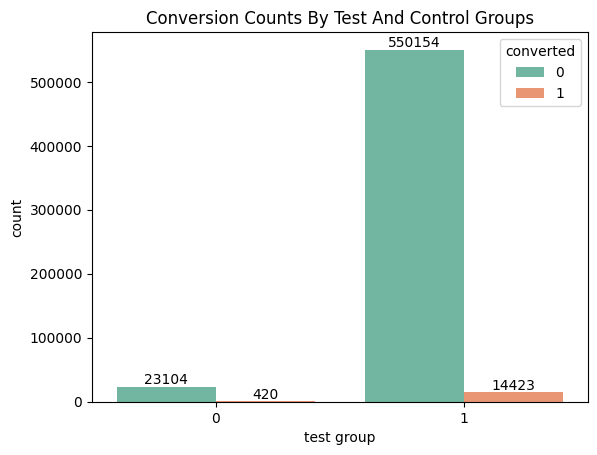

In [125]:
ax = sns.countplot(x = 'test group', hue = 'converted', data=data)

for container in ax.containers:
    ax.bar_label(container)

ax.set_title("Conversion Counts By Test And Control Groups")

plt.show()

Though at an aggregate level the test group contained 24x the control population but we observe ~34x the conversions in test vs control group suggesting some variations between the two

### Visualizing The Conversion Rates Between the Test And Control Groups

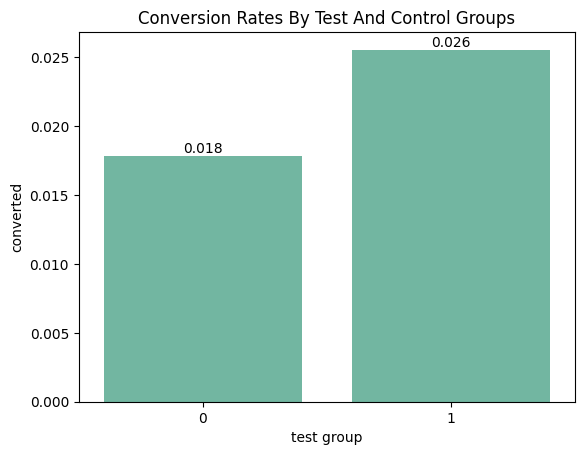

In [214]:
conversion_df = data.groupby('test group', as_index = False)['converted'].mean()

ax = sns.barplot(conversion_df, x = 'test group', y = 'converted')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

ax.set_title('Conversion Rates By Test And Control Groups')

plt.show()

At an aggregate level there is ~0.8% more conversion in test cohort compared to the control

### Visualizing Number Of Total Ads Seen

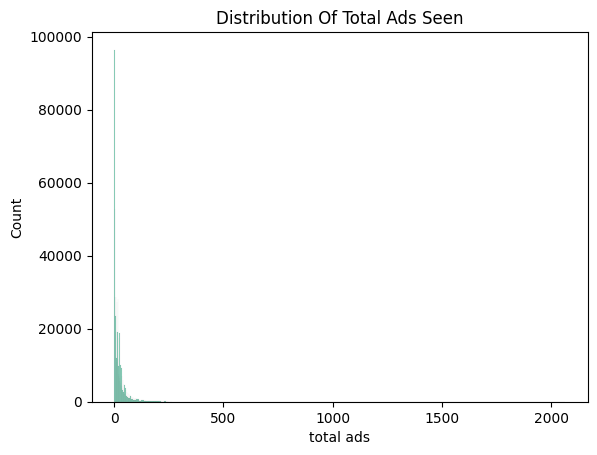

In [126]:
ax = sns.histplot(data, x= 'total ads')

ax.set_title("Distribution Of Total Ads Seen")

plt.show()

Total ads seen seem to be heavily right skewed by some outlier values and it would be worth deep diving into the values to see what is causing the issue

### Data Distribution Of Total Ads Seen

In [36]:
data['total ads'].describe()

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total ads, dtype: float64

With a low of 1 and median and 75th value at 13 and 27 respectively, it seems that majority of total ads seen by the users lies within the 1-30 range and outside this is where the outliers exist. It would be best to modify this column with some kind of transformation to get an approximate normal distribution

### Boxplot Of Total Ads Seen Split By Conversion Status

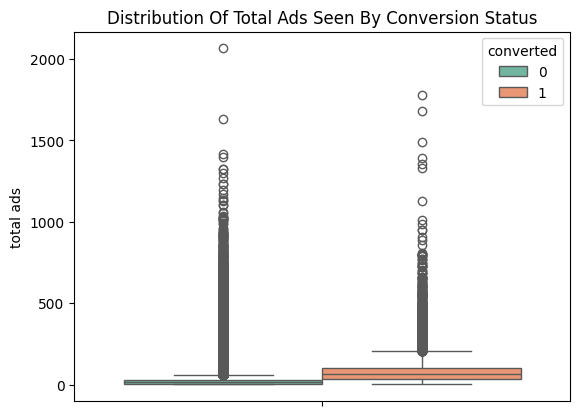

In [134]:
ax = sns.boxplot(data, y = 'total ads', hue = 'converted')

ax.set_title('Distribution Of Total Ads Seen By Conversion Status')

plt.show()

Although both converted and non-converted users exhibit substantial outliers in total ads viewed, the converted group still has a portion of users within the whisker range, whereas the non-converted group is highly compressed and largely dominated by extreme outliers

### Boxplot Of Log Transformed Total Ads Seen

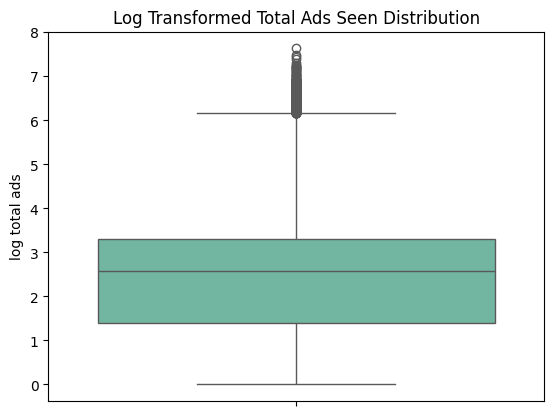

In [192]:
data['log total ads'] = np.log(data['total ads'])

ax = sns.boxplot(data['log total ads'])

ax.set_title('Log Transformed Total Ads Seen Distribution')

plt.show()

Applying a log transformation to total ads viewed reduces the influence of extreme outliers and yields a more interpretable distribution, however even after transformation, a number of notable outliers remain

### Visualizing Log Transformed Total Ads Seen By Test Cohorts And Conversion Status

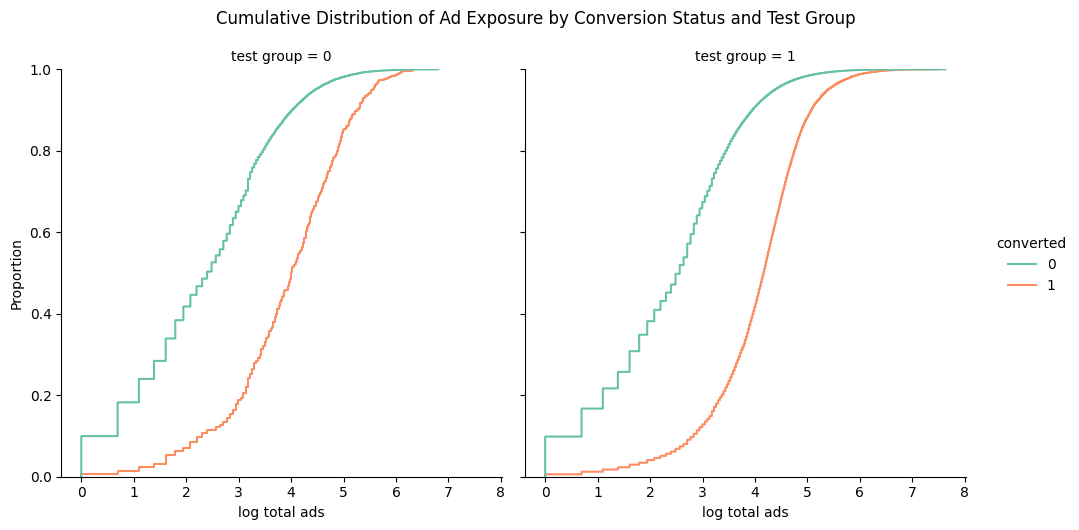

In [194]:
ax = sns.displot(data, x = 'log total ads', hue = 'converted', col = 'test group', kind = 'ecdf')

ax.fig.suptitle('Cumulative Distribution of Ad Exposure by Conversion Status and Test Group', y = 1.05)

plt.show()

Across both test and control groups, converted users consistently require higher ad exposure to reach the same cumulative proportion as non-converted users, indicating that conversion is associated with greater ad exposure. This separation is more pronounced in the test group, suggesting differential exposure dynamics between the two groups

### Visualizing The Days Most Ads Are Seen

/var/folders/yc/9z7h1gcx31ngfh95kkfgwf4m0000gn/T/ipykernel_57073/3338671502.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


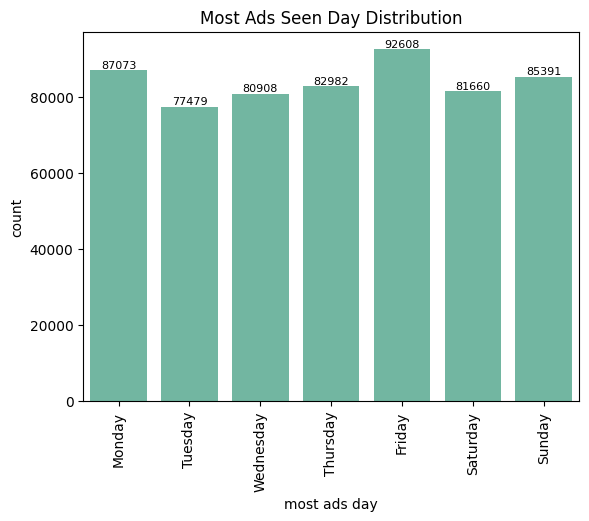

In [148]:
ax = sns.countplot(data, x = 'most ads day', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_title('Most Ads Seen Day Distribution')

for container in ax.containers:
    ax.bar_label(container, fontsize = 8)

plt.show()

There is limited variation in the day on which the most ads are seen, with a modest peak on Friday (~93k) and a trough on Tuesday (~77k). Apart from these minor deviations, ad exposure remains fairly consistent across other days, indicating no strong day-level preference.

### Visualizing Conversions By Days Most Ads Are Seen

/var/folders/yc/9z7h1gcx31ngfh95kkfgwf4m0000gn/T/ipykernel_57073/3210923884.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


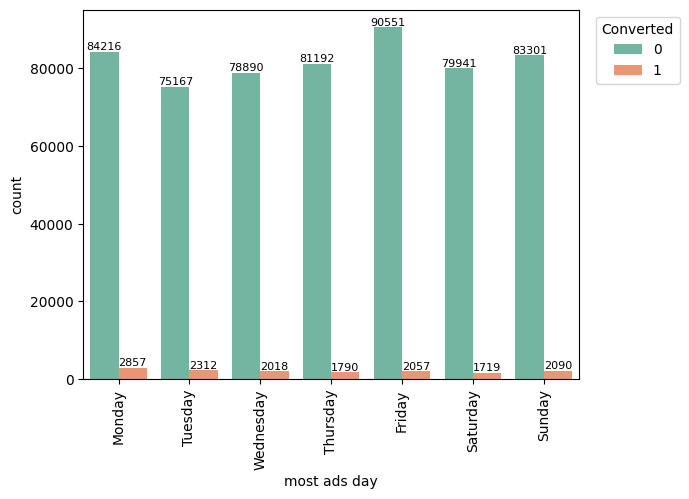

In [94]:
ax = sns.countplot(data, x = 'most ads day', hue = 'converted', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for container in ax.containers:
    ax.bar_label(container, fontsize = 8)

ax.legend(title='Converted', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

Despite Friday having the highest ad exposure, it does not yield the highest number of conversions. In contrast, Tuesday, despite having the lowest ad exposure, records the second-highest number of conversions at ~2.3k

### Visualizing Split of Conversions and Test Cohorts By The Days Most Ads Are Seen

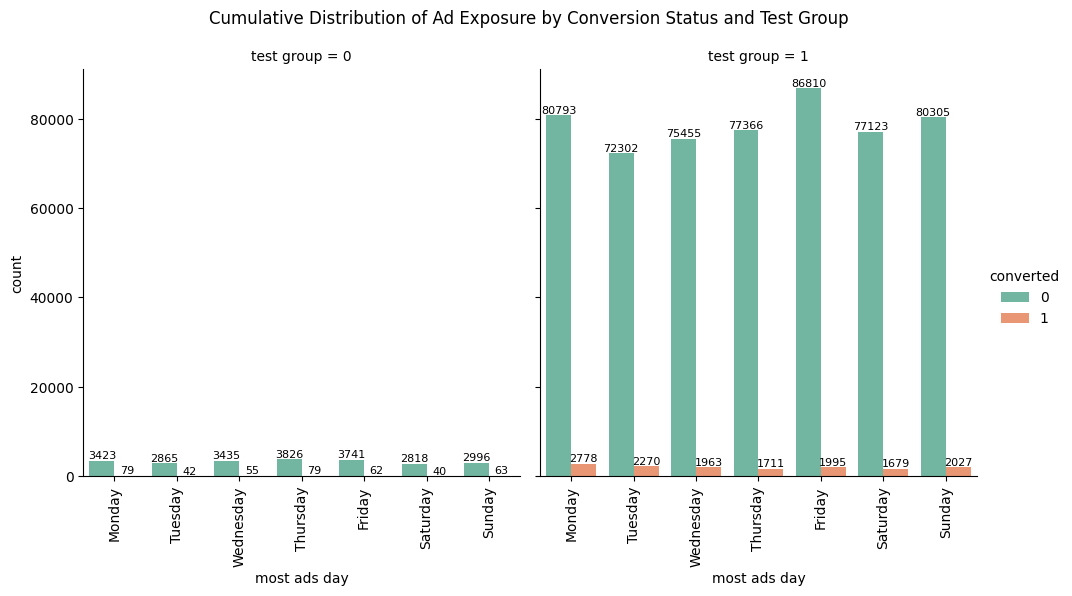

In [150]:
ax = sns.catplot(data, x = 'most ads day', hue = 'converted', col = 'test group', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], kind = 'count')

ax.set_xticklabels(rotation=90)

for g in ax.axes.flat:
    for container in g.containers:
        g.bar_label(container, fontsize = 8)

ax.fig.suptitle('Cumulative Distribution of Ad Exposure by Conversion Status and Test Group', y = 1.05)

plt.show()

The control group shows minimal variations in the conversion counts and when they see the most ads through the week and it is mainly the test group driving the variations

### Visualizing Conversion Rates By The Days Most Ads Are Seen

/var/folders/yc/9z7h1gcx31ngfh95kkfgwf4m0000gn/T/ipykernel_57073/1430947359.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


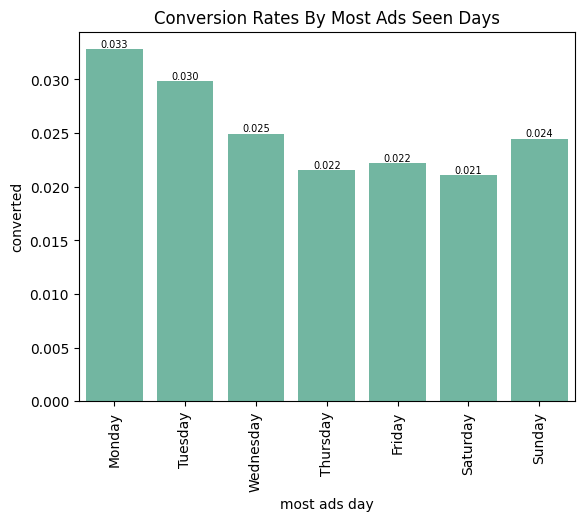

In [155]:
conversion_df = data.groupby(['most ads day'], as_index = False)['converted'].mean()

ax = sns.barplot(conversion_df, x = 'most ads day', y = 'converted', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_title('Conversion Rates By Most Ads Seen Days')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize = 7)

plt.show()

Greater proportion of conversions happen by the users who are exposed to the ad in first half of the week and then the conversion rate stabalizes in the second half with the exception of Sunday, registering a ~2.4% conversion by the users

### Visualizing Conversion Rates By Most Ads Seen Days And Cohort Type

/var/folders/yc/9z7h1gcx31ngfh95kkfgwf4m0000gn/T/ipykernel_57073/3437053756.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


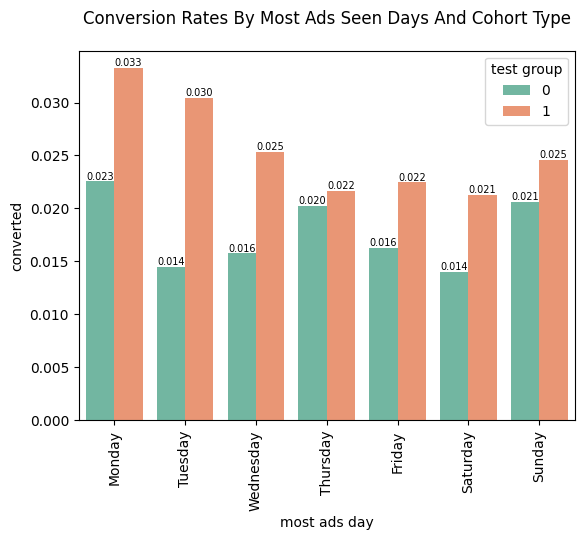

In [182]:
conversion_df = data.groupby(['most ads day', 'test group'], as_index = False)['converted'].mean()

ax = sns.barplot(conversion_df, x = 'most ads day', y = 'converted', hue = 'test group', order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.set_title('Conversion Rates By Most Ads Seen Days And Cohort Type', y = 1.05)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize = 7)

plt.show()

The control group shows no clear ordinal pattern in conversion rates across days of highest ad exposure. In contrast, the test group exhibits higher conversion rates earlier in the week, which then stabilize in the latter half

### Visualizing Users Distribution By Hour Of The Day When They Watch The Most Ads

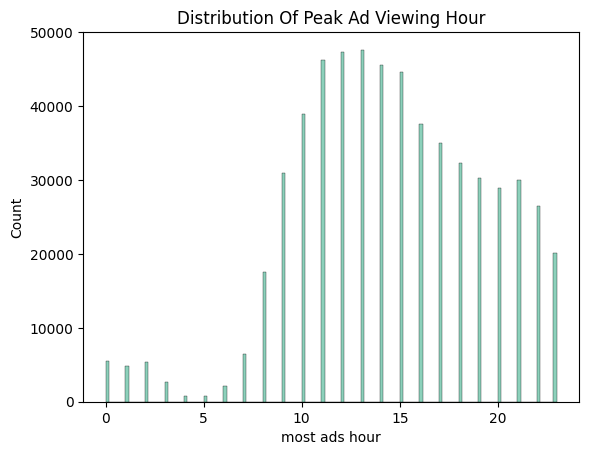

In [168]:
ax = sns.histplot(data['most ads hour'])

ax.set_title('Distribution Of Peak Ad Viewing Hour')

plt.show()

Per expectation, peak ad exposure is strongly concentrated during daytime and early evening hours, with a clear rise starting in the morning, peaking around midday to early afternoon, and gradually tapering off into the evening. Overnight and early-morning hours show minimal ad exposure, indicating that users are far less active during those periods.

### Visualizing Conversion Rates By Hour Of The Day When Most Ads Are Watched

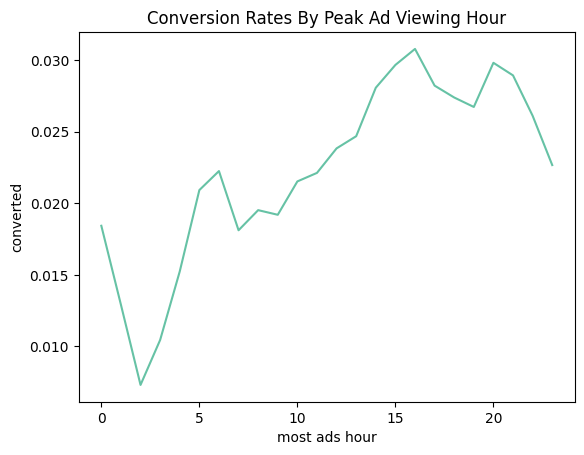

In [187]:
conversion_df = data.groupby(['most ads hour'], as_index = False)['converted'].mean()

ax = sns.lineplot(data, x = 'most ads hour', y = 'converted', errorbar = None)

ax.set_title('Conversion Rates By Peak Ad Viewing Hour')

plt.show()

In line with user distribution, conversion rates also pick up in morning and is concentrated in afternoon and evening before tapering off in the night and dipping in late night

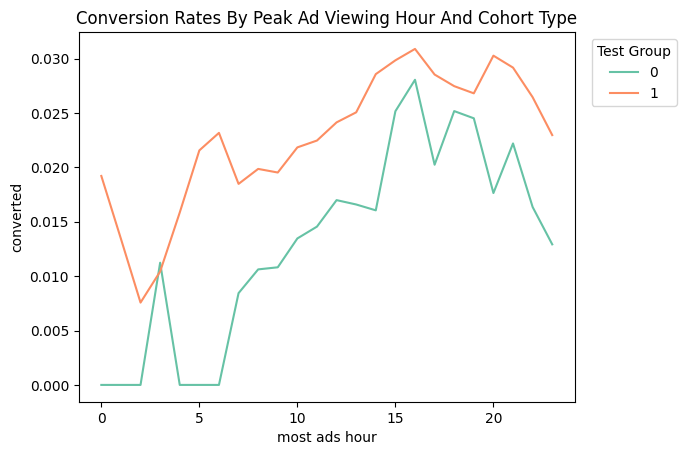

In [191]:
conversion_df = data.groupby(['most ads hour', 'test group'], as_index = False)['converted'].mean()

ax = sns.lineplot(data, x = 'most ads hour', y = 'converted', hue = 'test group', errorbar = None)

ax.set_title('Conversion Rates By Peak Ad Viewing Hour And Cohort Type')

ax.legend(title='Test Group', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

Conversion rates increase steadily through the day for both groups, peaking during late afternoon to early evening hours. The test group consistently outperforms the control group across almost all hours, with the largest uplift observed between mid-day and early evening, suggesting the treatment is most effective during peak engagement periods

Consolidated Exploratory Data Analysis Insights:

1. The dataset exhibits a significant imbalance between test and control groups, with the test group comprising the majority of users

2. Ad exposure is highly right-skewed, with a small subset of users experiencing disproportionately high ad volumes. Log transformation improves interpretability but does not fully eliminate extreme outliers

3. Converted and non-converted users both show heavy-tailed ad exposure distributions; however, converted users retain a meaningful central spread, whereas non-converted users are more compressed and dominated by extreme values

4. No strong day-of-week preference is observed for when users see the most ads. Although Friday shows the highest overall ad exposure and Tuesday the lowest, ad delivery remains broadly consistent across other days

5. Higher ad exposure does not directly translate into higher conversion counts. Notably, Tuesday—despite lower exposure—produces one of the highest conversion volumes, suggesting exposure quantity alone is not the sole driver of conversion

6. Peak ad veiwing hour analysis reveals that peak activity occurs during late morning to early evening hours and there exists minimal activity overnight

7. Conversion rates increase steadily throughout the day, peaking during late afternoon and early evening. Across nearly all hours, the test group consistently outperforms the control group, with the largest uplift observed during peak engagement periods

8. Overall, exploratory analysis suggests a positive association between ad exposure and conversion, with clear differences between test and control groups, warranting formal statistical hypothesis testing

# Chi Square Test Of Independence Between Cohort Types And Converted Status

Based on the exploratory data analysis conducted above, there is evidence to suggest a potential relationship between cohort assignment (test vs control) and conversion status. To formally evaluate this relationship, we perform a chi-square test of independence with the following hypotheses:

1. Null Hypothesis: Cohort assignment and conversion status are independent and the ad exposure has no effect on conversion
2. Alternative Hypothesis: Cohort assignment and conversion status are not independent and ad exposure influences conversion in the test group

The test is conducted at a 5% significance level

In [201]:
pivot = data.pivot_table(index = 'test group', columns = 'converted', values = 'total ads', aggfunc = 'count')

chi, p, dof, expected = chi2_contingency(pivot)

print(p)

1.9989623063390012e-13


Given that the p-value is well below the 5% significance level, we reject the null hypothesis and conclude that cohort assignment and conversion status are not independent, indicating a statistically significant impact of ad exposure on conversions

# Confidence Interval With Z Test For Proportions

Having established through a chi-square test that cohort type is associated with conversion status, we now estimate the confidence interval for the impact of ad exposure on the difference in conversion rates between the test and control groups

### 95% Confidence Interval

In [218]:
control_nsize = data.query("`test group` == 0").shape[0]
test_nsize = data.query("`test group` == 1").shape[0]

control_conversion_rate = data.query("`test group` == 0")['converted'].sum()/ control_nsize
test_conversion_rate = data.query("`test group` == 1")['converted'].sum()/ test_nsize

standard_error = np.sqrt((control_conversion_rate * (1 - control_conversion_rate) / control_nsize) + (test_conversion_rate * (1 - test_conversion_rate) / test_nsize))

difference = test_conversion_rate - control_conversion_rate

In [ ]:
z = norm.ppf(0.975)

print(f"Confidence interval lower limit: {difference - z * standard_error:.2%}")
print(f"Confidence interval upper limit: {difference + z * standard_error:.2%}")

Confidence interval lower limit: 0.60%
Confidence interval upper limit: 0.94%


With 95% confidence, the true uplift in conversion rate due to ad exposure lies between 0.6% and 0.94%

### 99% Confidence Level

In [219]:
z = norm.ppf(0.995)

print(f"Confidence interval lower limit: {difference - z * standard_error:.2%}")
print(f"Confidence interval upper limit: {difference + z * standard_error:.2%}")

Confidence interval lower limit: 0.54%
Confidence interval upper limit: 1.00%


With 99% confidence, the true uplift in conversion rate due to ad exposure lies between 0.54% and 1%

# Statistical Association Between Ad Exposure Features and Conversion Outcomes

Based on the exploratory data analysis conducted above, ad exposure related features (total ads shown, most ads day and most ads hour) appear to be associated with differences in conversion rates. Certain values within these features exhibit higher conversion values compared to others, suggesting potential internal differences.

Since ad exposure is only applicable to users in the test cohort, all subsequent analyses of ad exposure features are restricted to this group to ensure comparability and avoid confounding due to differing exposure mechanisms in the control cohort.

To formally validate these observations, we proceed with statistical hypothesis testing for each feature. For categorical ad exposure variables, we apply a chi-square test of independence to assess whether conversion status is independent of the feature. For numeric ad exposure variables, we use an independent two-sample t-test to evaluate whether conversion status differs significantly between the groups

### Statistical Validation For Most Ads Shown Feature: Two Samples Independent T Test

Based on the exploratory data analysis conducted, there is evidence to suggest a potential relationship between conversion status and the number of ads the users see. To formally evaluate this relationship, we perform a two samples independent t-test with the following hypotheses:

1. Null Hypothesis: Number of ads that a user see has no effect on conversion
2. Alternative Hypothesis: Numer of ads seen by a user ifluences the conversion

The test is conducted at a 5% significance level

In [234]:
converted_total_ads = data.query("`test group` == 1 & converted == 1")['total ads']
not_converted_total_ads = data.query("`test group` == 1 & converted == 0")['total ads']

tstat, p = ttest_ind(converted_total_ads, not_converted_total_ads, equal_var = False)

print(p)

0.0


Given that the p-value is well below the 5% significance level, we reject the null hypothesis and conclude that conversion status is not independent of the number of ads seen, indicating a statistically significant impact of number of ads exposure on conversions

### Statistical Validation For Most Ads Day Feature: Chi Square Test Of Independence

Based on the exploratory data analysis conducted, there is evidence to suggest a potential relationship between conversion status and the day when the user sees the most number of ads. To formally evaluate this relationship, we perform a chi-square test of independence with the following hypotheses:

1. Null Hypothesis: Day that a user sees the most ads has no effect on conversion
2. Alternative Hypothesis: Day that a user sees the most ads ifluences the conversion

The test is conducted at a 5% significance level

In [235]:
pivot = data.pivot_table(index = 'most ads day', columns = 'converted', values = 'most ads hour', aggfunc = 'count')

chi2, p, dof, expected = chi2_contingency(pivot)

print(p)

1.932184379244731e-85


Given that the p-value is well below the 5% significance level, we reject the null hypothesis and conclude that conversion status is not independent of the day when a user sees the most ads, indicating a statistically significant impact of the day with the most ads exposure on conversions

### Statistical Validation For Most Ads Hour Feature: Chi Square Test Of Independence

Based on the exploratory data analysis conducted, there is evidence to suggest a potential relationship between conversion status and the hour of the day when the user sees the most number of ads. To formally evaluate this relationship, we perform a chi-square test of independence with the following hypotheses:

1. Null Hypothesis: Hour of the day that a user sees the most ads has no effect on conversion
2. Alternative Hypothesis: Hour of the day that a user sees the most ads ifluences the conversion

The test is conducted at a 5% significance level

In [239]:
pivot = data.pivot_table(index = 'most ads hour', columns = 'converted', values = 'most ads day', aggfunc = 'count')

chi2, p, dof, expected = chi2_contingency(pivot)

print(p)

8.027629823696774e-77


Given that the p-value is well below the 5% significance level, we reject the null hypothesis and conclude that conversion status is not independent of the hour of the day when a user sees the most ads, indicating a statistically significant impact of hour of the day with the most ads exposure on conversions